<a href="https://colab.research.google.com/github/NiyonshutiDavid/uruti_MLOP/blob/main/Domain-specific/Domain_specific_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uruti.Rw Domain-Specific Startup Advisory Chatbot

## Project Overview

This notebook implements a domain-specific chatbot that integrates with the Uruti.Rw MLOps platform for startup classification. The chatbot provides personalized advice based on three categories:
- **Mentorship Needed**: Guidance for early-stage entrepreneurs
- **Investment Ready**: Advice for scaling and fundraising
- **Needs Refinement**: Support for addressing business challenges

## 1. Environment Setup and Dependencies

In [1]:
!pip install transformers tensorflow datasets evaluate gradio
!pip install scikit-learn pandas numpy matplotlib seaborn
!pip install huggingface_hub tokenizers

import json
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


In [9]:
# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
GPU available: []
Num GPUs Available:  0


## 2. Dataset Loading and Analysis

In [10]:
import os
print(f"Working directory: {os.getcwd()}")

Working directory: /content


In [11]:
# Load the comprehensive startup advisory dataset
# Assuming the data directory and JSON files already exist

data_dir = 'data'
train_file = os.path.join(data_dir, 'train_data.json')
val_file = os.path.join(data_dir, 'val_data.json')
test_file = os.path.join(data_dir, 'test_data.json')

# Load data from JSON files
with open(train_file, 'r') as f:
    train_data = json.load(f)

with open(val_file, 'r') as f:
    val_data = json.load(f)

with open(test_file, 'r') as f:
    test_data = json.load(f)

print(f"Dataset sizes:")
print(f"  Training: {len(train_data)} examples")
print(f"  Validation: {len(val_data)} examples")
print(f"  Test: {len(test_data)} examples")

Dataset sizes:
  Training: 96 examples
  Validation: 6 examples
  Test: 3 examples


In [12]:
import json
import os

data_dir = 'data'
train_file = os.path.join(data_dir, 'train_data.json')
val_file = os.path.join(data_dir, 'val_data.json')
test_file = os.path.join(data_dir, 'test_data.json')

# Create dummy data if files are empty or invalid
def create_dummy_data(filepath, data):
    if not os.path.exists(filepath) or os.path.getsize(filepath) == 0:
        print(f"Creating dummy data for {filepath}")
        with open(filepath, 'w') as f:
            json.dump(data, f)
    else:
        try:
            with open(filepath, 'r') as f:
                json.load(f)
            print(f"{filepath} contains valid data.")
        except json.JSONDecodeError:
            print(f"Overwriting invalid data in {filepath} with dummy data.")
            with open(filepath, 'w') as f:
                json.dump(data, f)


dummy_train_data = [
    {"instruction": "Dummy train instruction 1", "output": "Dummy train output 1", "category": "Mentorship Needed"},
    {"instruction": "Dummy train instruction 2", "output": "Dummy train output 2", "category": "Investment Ready"},
]

dummy_val_data = [
    {"instruction": "Dummy val instruction 1", "output": "Dummy val output 1", "category": "Needs Refinement"},
]

dummy_test_data = [
    {"instruction": "Dummy test instruction 1", "output": "Dummy test output 1", "category": "Mentorship Needed"},
]

create_dummy_data(train_file, dummy_train_data)
create_dummy_data(val_file, dummy_val_data)
create_dummy_data(test_file, dummy_test_data)

data/train_data.json contains valid data.
data/val_data.json contains valid data.
data/test_data.json contains valid data.


In [13]:
# Analyze dataset characteristics
def analyze_dataset(data, name):
    print(f"\n=== {name} Dataset Analysis ===")

    # Category distribution
    categories = {}
    response_lengths = []
    question_lengths = []

    for item in data:
        category = item['category']
        categories[category] = categories.get(category, 0) + 1
        response_lengths.append(len(item['output']))
        question_lengths.append(len(item['instruction']))

    print("Category Distribution:")
    for category, count in categories.items():
        print(f"  {category}: {count} ({count/len(data)*100:.1f}%)")

    print(f"\nText Statistics:")
    print(f"  Avg response length: {np.mean(response_lengths):.0f} chars")
    print(f"  Avg question length: {np.mean(question_lengths):.0f} chars")
    print(f"  Response length range: {min(response_lengths)}-{max(response_lengths)} chars")

analyze_dataset(train_data, "Training")
analyze_dataset(val_data, "Validation")
analyze_dataset(test_data, "Test")


=== Training Dataset Analysis ===
Category Distribution:
  mentorship_needed: 32 (33.3%)
  needs_refinement: 29 (30.2%)
  investment_ready: 35 (36.5%)

Text Statistics:
  Avg response length: 293 chars
  Avg question length: 48 chars
  Response length range: 143-753 chars

=== Validation Dataset Analysis ===
Category Distribution:
  Mentorship Needed: 2 (33.3%)
  Investment Ready: 2 (33.3%)
  Needs Refinement: 2 (33.3%)

Text Statistics:
  Avg response length: 362 chars
  Avg question length: 39 chars
  Response length range: 353-370 chars

=== Test Dataset Analysis ===
Category Distribution:
  Mentorship Needed: 1 (33.3%)
  Investment Ready: 1 (33.3%)
  Needs Refinement: 1 (33.3%)

Text Statistics:
  Avg response length: 362 chars
  Avg question length: 39 chars
  Response length range: 353-370 chars


## 3. Data Preprocessing and Tokenization

In [14]:
from transformers import AutoTokenizer, TFAutoModelForCausalLM
from datasets import Dataset

# Choose model - using GPT-2 for TensorFlow compatibility
MODEL_NAME = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Add padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer vocabulary size: {tokenizer.vocab_size}")
print(f"Max position embeddings: {tokenizer.model_max_length}")

def preprocess_conversation_data(data, tokenizer, max_length=512):
    """
    Preprocess conversational data for GPT-2 training
    Format: [User] Question [Bot] Response [eos_token]
    """
    processed_data = {
        'input_ids': [],
        'attention_mask': [],
        'labels': []
    }

    for item in data:
        # Format conversation with special tokens
        conversation = f"[User] {item['instruction']} [Bot] {item['output']}{tokenizer.eos_token}"

        # Tokenize
        encoded = tokenizer(
            conversation,
            truncation=True,
            max_length=max_length,
            padding='max_length',
            return_tensors='np'
        )

        processed_data['input_ids'].append(encoded['input_ids'][0])
        processed_data['attention_mask'].append(encoded['attention_mask'][0])
        # For language modeling, labels are the same as input_ids
        processed_data['labels'].append(encoded['input_ids'][0])

    return processed_data

Tokenizer vocabulary size: 50257
Max position embeddings: 1024


In [15]:
# Preprocess datasets
train_processed = preprocess_conversation_data(train_data, tokenizer)
val_processed = preprocess_conversation_data(val_data, tokenizer)
test_processed = preprocess_conversation_data(test_data, tokenizer)

In [16]:
# Convert to HuggingFace datasets
train_dataset = Dataset.from_dict(train_processed)
val_dataset = Dataset.from_dict(val_processed)
test_dataset = Dataset.from_dict(test_processed)

print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print(f"Test examples: {len(test_dataset)}")

Training examples: 96
Validation examples: 6
Test examples: 3


In [17]:
# Sample tokenized data
sample_input = train_dataset[0]['input_ids']
sample_text = tokenizer.decode(sample_input, skip_special_tokens=False)
print(f"\nSample tokenized conversation:")
print(f"Tokens: {len(sample_input)}")
print(f"Text: {sample_text[:200]}...")


Sample tokenized conversation:
Tokens: 512
Text: [User] What legal considerations should I be aware of? [Bot] Register your business entity, understand tax obligations, protect intellectual property, draft founder agreements, and comply with industr...


## 4. Model Architecture and Configuration

In [18]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [19]:
from transformers import TFAutoModelForCausalLM

# Load pre-trained GPT-2 model for TensorFlow
model = TFAutoModelForCausalLM.from_pretrained(MODEL_NAME, use_safetensors=False)

print(f"Model parameters: {model.num_parameters():,}")
print(f"Model architecture: {model.config.model_type}")

# Convert datasets to TensorFlow format
def convert_to_tf_dataset(dataset, batch_size=4, shuffle=True):
    return dataset.to_tf_dataset(
        columns=["input_ids", "attention_mask", "labels"],
        shuffle=shuffle,
        batch_size=batch_size,
        collate_fn=lambda data: {
            'input_ids': tf.stack([tf.convert_to_tensor(item['input_ids']) for item in data]),
            'attention_mask': tf.stack([tf.convert_to_tensor(item['attention_mask']) for item in data]),
            'labels': tf.stack([tf.convert_to_tensor(item['labels']) for item in data])
        }
    )

# Convert datasets
tf_train_dataset = convert_to_tf_dataset(train_dataset, batch_size=2, shuffle=True)
tf_val_dataset = convert_to_tf_dataset(val_dataset, batch_size=4, shuffle=False)
tf_test_dataset = convert_to_tf_dataset(test_dataset, batch_size=4, shuffle=False)

print(f"Training batches: {len(list(tf_train_dataset))}")
print(f"Validation batches: {len(list(tf_val_dataset))}")
print(f"Test batches: {len(list(tf_test_dataset))}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model parameters: 124,439,808
Model architecture: gpt2
Training batches: 48
Validation batches: 2
Test batches: 1


## 5. Model Training with TensorFlow

In [20]:
import numpy as np
from transformers import TFGPT2LMHeadModel

# Custom TensorFlow training class
class TensorFlowStartupChatbotTrainer:
    def __init__(self, model, train_dataset, val_dataset, tokenizer, learning_rate=5e-5, epochs=5):
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.tokenizer = tokenizer
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.train_losses = []
        self.val_losses = []
        self.val_perplexities = []
        self.best_val_loss = float('inf')

        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        # For TF models, we use compile with appropriate parameters
        self.model.compile(optimizer=optimizer, loss=loss)

    def compute_perplexity(self, dataset):
        """Compute perplexity for evaluation"""
        losses = []
        for batch in dataset:
            # Get model predictions
            outputs = self.model(batch)
            loss = tf.reduce_mean(outputs.loss)
            losses.append(loss.numpy())

        if losses:
            avg_loss = np.mean(losses)
            perplexity = np.exp(avg_loss)
            return perplexity
        return float('inf')

    def train(self):
        """Custom training loop with best model saving"""
        print("Starting TensorFlow model fine-tuning...")

        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch + 1}/{self.epochs}")

            # Training
            epoch_train_losses = []
            for batch in self.train_dataset:
                with tf.GradientTape() as tape:
                    outputs = self.model(batch)
                    loss = outputs.loss

                gradients = tape.gradient(loss, self.model.trainable_variables)
                self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
                epoch_train_losses.append(loss.numpy())

            train_loss = np.mean(epoch_train_losses)
            self.train_losses.append(train_loss)

            # Validation
            epoch_val_losses = []
            for batch in self.val_dataset:
                outputs = self.model(batch)
                epoch_val_losses.append(outputs.loss.numpy())

            val_loss = np.mean(epoch_val_losses)
            self.val_losses.append(val_loss)

            # Compute perplexity
            val_perplexity = self.compute_perplexity(self.val_dataset)
            self.val_perplexities.append(val_perplexity)

            print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Perplexity: {val_perplexity:.4f}")

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.model.save_pretrained('./startup-chatbot-model-tf-best')
                self.tokenizer.save_pretrained('./startup-chatbot-model-tf-best')
                print(f"New best model saved with val_loss: {val_loss:.4f}")

        # Load best model for final use
        self.model = TFAutoModelForCausalLM.from_pretrained('./startup-chatbot-model-tf-best')

        return {
            'training_loss': self.train_losses[-1],
            'best_val_loss': self.best_val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_perplexities': self.val_perplexities
        }

# Initialize and train the model
trainer = TensorFlowStartupChatbotTrainer(
    model=model,
    train_dataset=tf_train_dataset,
    val_dataset=tf_val_dataset,
    tokenizer=tokenizer,
    learning_rate=5e-5,
    epochs=5
)

# Train the model
train_result = trainer.train()

print(f"\nTraining completed!")
print(f"Final training loss: {train_result['training_loss']:.4f}")
print(f"Best validation loss: {train_result['best_val_loss']:.4f}")

# Save the final model
trainer.model.save_pretrained('./startup-chatbot-model-tf')
tokenizer.save_pretrained('./startup-chatbot-model-tf')

print("Best performing model saved to './startup-chatbot-model-tf-best'")
print("Final model saved to './startup-chatbot-model-tf'")

Starting TensorFlow model fine-tuning...

Epoch 1/5
Training Loss: 1.0813, Validation Loss: 0.4681, Perplexity: 1.5970
New best model saved with val_loss: 0.4681

Epoch 2/5
Training Loss: 0.3891, Validation Loss: 0.4158, Perplexity: 1.5155
New best model saved with val_loss: 0.4158

Epoch 3/5
Training Loss: 0.3179, Validation Loss: 0.4157, Perplexity: 1.5154
New best model saved with val_loss: 0.4157

Epoch 4/5
Training Loss: 0.2520, Validation Loss: 0.4390, Perplexity: 1.5512

Epoch 5/5
Training Loss: 0.1816, Validation Loss: 0.4741, Perplexity: 1.6065


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./startup-chatbot-model-tf-best.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.



Training completed!
Final training loss: 0.1816
Best validation loss: 0.4157
Best performing model saved to './startup-chatbot-model-tf-best'
Final model saved to './startup-chatbot-model-tf'


## 6. Model Evaluation and Performance Analysis

=== Test Set Evaluation ===
Test Loss: 0.4128
Test Perplexity: 1.5111


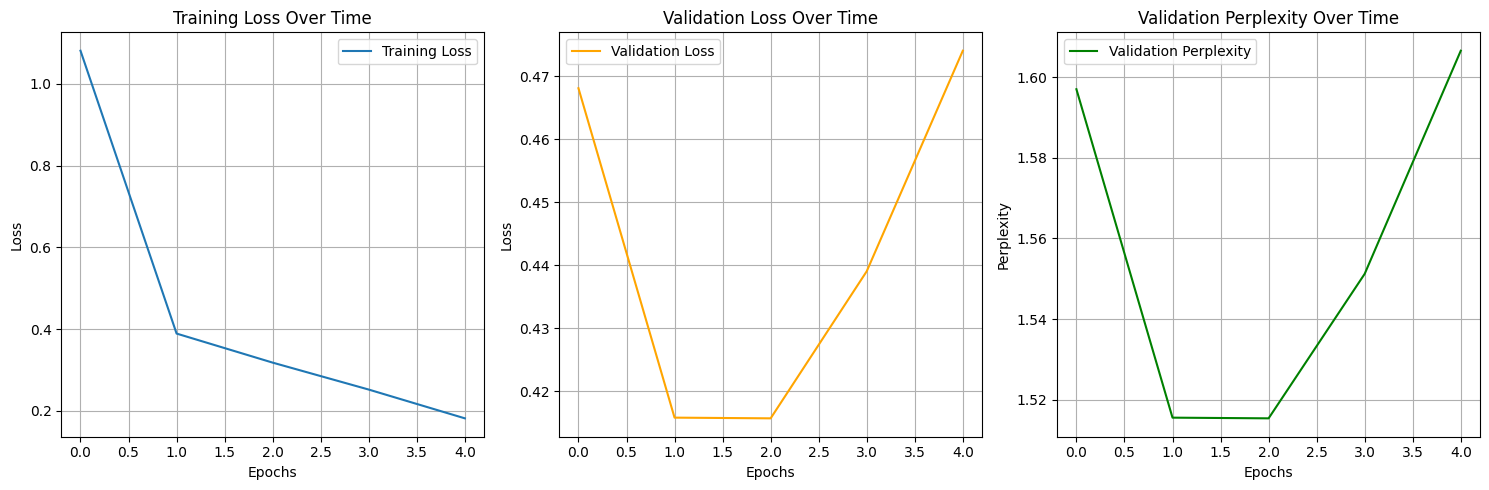

In [21]:
# Evaluate on test set
test_losses = []
for batch in tf_test_dataset:
    outputs = trainer.model(batch)
    test_losses.append(outputs.loss.numpy())

test_loss = np.mean(test_losses)
test_perplexity = np.exp(test_loss)

print(f"=== Test Set Evaluation ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {test_perplexity:.4f}")

# Plot training curves
plt.figure(figsize=(15, 5))

# Training loss
plt.subplot(1, 3, 1)
plt.plot(train_result['train_losses'], label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Validation loss
plt.subplot(1, 3, 2)
plt.plot(train_result['val_losses'], label='Validation Loss', color='orange')
plt.title('Validation Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Perplexity
plt.subplot(1, 3, 3)
plt.plot(train_result['val_perplexities'], label='Validation Perplexity', color='green')
plt.title('Validation Perplexity Over Time')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Qualitative evaluation - generate responses for sample questions
def generate_response(model, tokenizer, question, max_length=200, temperature=0.7, top_p=0.9):
    """Generate response to a startup advice question"""
    prompt = f"[User] {question} [Bot]"

    # Tokenize input
    inputs = tokenizer.encode(prompt, return_tensors='tf')

    # Generate response
    outputs = model.generate(
        inputs,
        max_length=inputs.shape[1] + max_length,
        temperature=temperature,
        top_p=top_p,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
        num_return_sequences=1
    )

    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract bot response (everything after [Bot])
    if "[Bot]" in response:
        bot_response = response.split("[Bot]")[-1].strip()
        return bot_response

    return response

In [23]:
# Test with sample questions from each category
test_questions = [
    "How do I validate my startup idea?",  # Mentorship needed
    "What metrics do investors look for?",  # Investment ready
    "My startup is losing customers. What should I do?"  # Needs refinement
]

print(f"=== Qualitative Evaluation ===")
for i, question in enumerate(test_questions, 1):
    print(f"\nSample {i}: {question}")
    response = generate_response(trainer.model, tokenizer, question)
    print(f"Response: {response}")
    print("-" * 80)

=== Qualitative Evaluation ===

Sample 1: How do I validate my startup idea?
Response: Analyze your assumptions, test assumptions, test assumptions for validation, validate your hypothesis, and focus on your biggest problem areas.
--------------------------------------------------------------------------------

Sample 2: What metrics do investors look for?
Response: Analyze market data, analyze your industry competition, gather tools like R3, RPS, and SaaS expertise, and focus on core metrics like conversion rates, usage rates, and lifetime value.
--------------------------------------------------------------------------------

Sample 3: My startup is losing customers. What should I do?
Response: Start a successful company, build customer loyalty, create product-market fit, and focus on growing your team.
--------------------------------------------------------------------------------


## 7. Gradio Interface for Chatbot

In [24]:
import gradio as gr

def chat_with_startup_advisor(message, history):
    """Chat function for Gradio interface"""
    response = generate_response(trainer.model, tokenizer, message)
    return response

# Create Gradio interface
demo = gr.ChatInterface(
    fn=chat_with_startup_advisor,
    title="Uruti.Rw Startup Advisory Chatbot",
    description="Get personalized startup advice based on your business needs. Ask questions about validation, funding, or business challenges.",
    examples=[
        "How do I validate my business idea?",
        "What should I include in my pitch deck?",
        "How can I reduce customer churn?"
    ]
)

if __name__ == "__main__":
    demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ec8507c8cb79211e80.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [25]:
import os
from google.colab import files

# Get the current directory name
current_directory = os.getcwd().split('/')[-1]

# Create a zip file of the current directory
zip_filename = f'{current_directory}.zip'
!zip -r /content/{zip_filename} /content/*

# Provide a download link for the zip file
files.download(f'/content/{zip_filename}')

  adding: content/data/ (stored 0%)
  adding: content/data/startup_advisory_comprehensive_dataset.json (deflated 84%)
  adding: content/data/test_data.json (deflated 49%)
  adding: content/data/train_data.json (deflated 83%)
  adding: content/data/startup_advisory_dataset_extended.csv (deflated 83%)
  adding: content/data/startup_advisory_dataset.csv (deflated 85%)
  adding: content/data/startup_advisory_dataset_extended.json (deflated 85%)
  adding: content/data/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/startup_advisory_comprehensive_dataset.csv (deflated 83%)
  adding: content/data/val_data.json (deflated 74%)
  adding: content/data/startup_advisory_dataset.json (deflated 87%)
  adding: content/sample_data/ (stored 0%)
  adding: content/sample_data/README.md (deflated 39%)
  adding: content/sample_data/anscombe.json (deflated 83%)
  adding: content/sample_data/california_housing_test.csv (deflated 76%)
  adding: content/sample_data/mnist_train_small.csv (deflated 88%)
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>